# Dependencies/Setup

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
import torch.optim as optim
from torch.autograd import Variable
import pdb
import matplotlib.pyplot as plt
import itertools

In [0]:
use_cuda = torch.cuda.is_available()

# Models

## Generator

In [0]:
class Generator(nn.Module):
  def __init__(self, input_size=100, output_size=28*28):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(input_size, 256)
    self.fc2 = nn.Linear(self.fc1.out_features, 512)
    self.fc3 = nn.Linear(self.fc2.out_features, 1024)
    self.fc4 = nn.Linear(self.fc3.out_features, output_size)
  
  def forward(self, x):
    x = F.leaky_relu(self.fc1(x), 0.2)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = F.leaky_relu(self.fc3(x), 0.2)
    x = F.tanh(self.fc4(x))
    
    return x

In [0]:
G_lr = 0.0002
G = Generator().cuda() if use_cuda else Generator()
G_optimizer = optim.Adam(G.parameters(), lr=G_lr)

## Discriminator

In [0]:
class Discriminator(nn.Module):
  def __init__(self, input_size=28*28, output_size=1):
    super(Discriminator, self).__init__()
    self.fc1 = nn.Linear(input_size, 1024)
    self.fc2 = nn.Linear(self.fc1.out_features, 512)
    self.fc3 = nn.Linear(self.fc2.out_features, 256)
    self.fc4 = nn.Linear(self.fc3.out_features, 1)
  
  def forward(self, x):
    x = F.leaky_relu(self.fc1(x), 0.2)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = F.leaky_relu(self.fc3(x), 0.2)
    x = F.sigmoid(self.fc4(x))
    return x

In [0]:
D_lr = 0.0002
D = Discriminator().cuda() if use_cuda else Discriminator()
D_optimizer = optim.Adam(D.parameters(), lr=D_lr)

# Data

In [0]:
batch_size = 64

In [0]:
mnist_normalization = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
mnist_dataset = datasets.MNIST('data', train=True, transform=mnist_normalization, download=True)
data_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

In [0]:
bce_loss = nn.BCELoss()

# Utilities

In [0]:
def put_tensor_in_cuda_variable(tensor, use_cuda, volatile=False):
  if (use_cuda):
    tensor = tensor.cuda()
  return Variable(tensor, volatile=volatile)

In [0]:
def show_generator_result(generator, batch_noise, rows=5, cols=5, 
                          label="Generator results"):
  generator.eval()
  
  batch_noise = put_tensor_in_cuda_variable(batch_noise, use_cuda)
  batch_images = generator(batch_noise)
  
  fig, ax = plt.subplots(rows, cols, figsize=(rows, cols))
  for i, j in itertools.product(range(rows), range(cols)):
    ax[i, j].get_xaxis().set_visible(False)
    ax[i, j].get_yaxis().set_visible(False)
  
  # total = rows * cols if rows * cols <= batch_noise.size()[0] else total = batch_noise.size()[0]
  for k in range(rows * cols):
    i = k//5
    j = k%5
    ax[i, j].cla()
    ax[i, j].imshow(batch_images[k, :].cpu().data.view(28, 28).numpy(), cmap='gray')
  
  plt.suptitle(label, fontsize=16)

  plt.show()

  
  generator.train()

In [0]:
def save_model(generator, discriminator, epoch):
  torch.save(generator.state_dict(), './generator{}.model'.format(epoch))
  torch.save(discriminator.state_dict(), './discriminator{}.model'.format(epoch))

# Optimization

## Discriminator

In [0]:
def train_discriminator(real_samples_flatten, current_batch_size, discriminator, generator, discriminator_optimizer):
  
  discriminator.zero_grad()
  
  
  noise = torch.randn((current_batch_size, 100))
  noise = put_tensor_in_cuda_variable(noise, use_cuda)
  fake_samples = generator(noise)
  
  d_real_target = torch.ones(current_batch_size)
  d_real_target = put_tensor_in_cuda_variable(d_real_target, use_cuda)
  d_real = discriminator(real_samples_flatten)
  d_real_loss = bce_loss(d_real, d_real_target)
  
  d_fake_target = torch.zeros(current_batch_size)
  d_fake_target = put_tensor_in_cuda_variable(d_fake_target, use_cuda)
  d_fake = discriminator(fake_samples)
  d_fake_loss = bce_loss(d_fake, d_fake_target)
  
  d_total_loss = d_fake_loss + d_real_loss
  d_total_loss.backward()
  discriminator_optimizer.step()

## Generator

In [0]:
def train_generator(current_batch_size, discriminator, generator, generator_optimizer):
  generator.zero_grad()
  
  noise = torch.randn((current_batch_size, 100))
  noise = put_tensor_in_cuda_variable(noise, use_cuda)
  
  fake_samples = generator(noise)
  d_real_target = torch.ones(current_batch_size)
  d_real_target = put_tensor_in_cuda_variable(d_real_target, use_cuda)
  
  d_fake = discriminator(fake_samples)
  
  g_loss = bce_loss(d_fake, d_real_target)
  g_loss.backward()
  generator_optimizer.step()

# Training

In [0]:
def train(discriminator, discriminator_optimizer, generator, generator_optimizer, data_loader, num_epochs=100):
  for epoch in range(num_epochs):
    print('---------------------')
    print('Epoch: {}'.format(epoch))
    for real_sample, _ in data_loader:
      real_samples_flatten = real_sample.view(-1, 28 * 28)
      real_samples_flatten = put_tensor_in_cuda_variable(real_samples_flatten, use_cuda)
      current_batch_size = real_samples_flatten.size()[0]
  
      train_discriminator(real_samples_flatten, current_batch_size, discriminator, generator, discriminator_optimizer)
      train_generator(current_batch_size, discriminator, generator, generator_optimizer)
      

In [17]:
train(D, D_optimizer, G, G_optimizer, data_loader)

---------------------
Epoch: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


---------------------
Epoch: 1
---------------------
Epoch: 2
---------------------
Epoch: 3
---------------------
Epoch: 4
---------------------
Epoch: 5
---------------------
Epoch: 6
---------------------
Epoch: 7
---------------------
Epoch: 8
---------------------
Epoch: 9
---------------------
Epoch: 10
---------------------
Epoch: 11
---------------------
Epoch: 12
---------------------
Epoch: 13
---------------------
Epoch: 14
---------------------
Epoch: 15
---------------------
Epoch: 16
---------------------
Epoch: 17
---------------------
Epoch: 18
---------------------
Epoch: 19
---------------------
Epoch: 20
---------------------
Epoch: 21
---------------------
Epoch: 22
---------------------
Epoch: 23
---------------------
Epoch: 24
---------------------
Epoch: 25
---------------------
Epoch: 26
---------------------
Epoch: 27
---------------------
Epoch: 28
---------------------
Epoch: 29
---------------------
Epoch: 30
---------------------
Epoch: 31
-----------------

---------------------
Epoch: 79
---------------------
Epoch: 80
---------------------
Epoch: 81
---------------------
Epoch: 82
---------------------
Epoch: 83
---------------------
Epoch: 84
---------------------
Epoch: 85
---------------------
Epoch: 86
---------------------
Epoch: 87
---------------------
Epoch: 88
---------------------
Epoch: 89
---------------------
Epoch: 90
---------------------
Epoch: 91
---------------------
Epoch: 92
---------------------
Epoch: 93
---------------------
Epoch: 94
---------------------
Epoch: 95
---------------------
Epoch: 96
---------------------
Epoch: 97
---------------------
Epoch: 98
---------------------
Epoch: 99


# Results

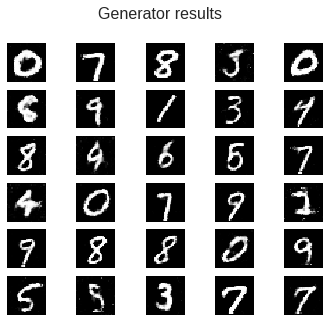

In [18]:
batch_noise = torch.randn(30, 100)
show_generator_result(G, batch_noise, rows=6, cols=5)

# Saving/Loading Model

In [0]:
save_model(G, D, 100)

In [0]:
generator100 = Generator().cuda() if use_cuda else Generator()
generator100.load_state_dict(torch.load('./generator100.model'))

In [0]:
discriminator100 = Discriminator().cuda() if use_cuda else Discriminator()
discriminator100.load_state_dict(torch.load('./discriminator100.model'))

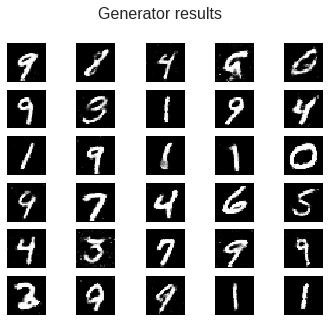

In [34]:
batch_noise = torch.randn(30, 100)
show_generator_result(generator100, batch_noise, rows=6, cols=5)